In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import folium, math
import matplotlib.pyplot as plt
import seaborn as sns

# Dataset list
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/coronavirusdataset/TimeAge.csv
/kaggle/input/coronavirusdataset/Region.csv
/kaggle/input/coronavirusdataset/Time.csv
/kaggle/input/coronavirusdataset/Weather.csv
/kaggle/input/coronavirusdataset/SearchTrend.csv
/kaggle/input/coronavirusdataset/TimeProvince.csv
/kaggle/input/coronavirusdataset/TimeGender.csv
/kaggle/input/coronavirusdataset/PatientInfo.csv
/kaggle/input/coronavirusdataset/PatientRoute.csv
/kaggle/input/coronavirusdataset/SeoulFloating.csv
/kaggle/input/coronavirusdataset/Case.csv


## 1. 집단감염 발생지 지도 시각화(folium) - Case.csv
- 집단감염 발생지를 지도에 표시함으로써, 수도권-대전-대구/경북으로 이어지는 벨트에 집단감염 사례가 집중되어 있는 추세를 발견함

In [2]:
# Load & Extract data - group case & geocode not null('-')
case_df = pd.read_csv('/kaggle/input/coronavirusdataset/Case.csv')
group_case_df = case_df[(case_df.group == True) & (case_df.latitude != '-')].drop('group', axis=1)

print(f'df shape before & after extraction : from {case_df.shape}  ->  to {group_case_df.shape}')
group_case_df.head()

df shape before & after extraction : from (102, 8)  ->  to (31, 7)


,case_id,province,city,infection_case,confirmed,latitude,longitude
0,1000001,Seoul,Guro-gu,Guro-gu Call Center,96,37.508163,126.884387
1,1000002,Seoul,Dongdaemun-gu,Dongan Church,20,37.592888,127.056766
2,1000003,Seoul,Guro-gu,Manmin Central Church,20,37.481059,126.894343
3,1000004,Seoul,Eunpyeong-gu,Eunpyeong St. Mary's Hospital,14,37.63369,126.9165
4,1000005,Seoul,Seongdong-gu,Seongdong-gu APT,13,37.55713,127.0403


In [3]:
# ref : https://www.kaggle.com/marcuswingen/analysis-of-covid-19-data-from-south-korea/data (Analysis of COVID-19 data from South Korea - by Marcus Wingen)
# Visualize using folium

route_map = folium.Map(location=[36.5,128],
                       width='70%', height='60%',
                       min_zoom=3, max_zoom=10,
                       zoom_start=6.5, tiles="cartodbpositron")

for lat, lon, count, city, case in zip(group_case_df.latitude, group_case_df.longitude,
                                       group_case_df.confirmed, group_case_df.city,
                                       group_case_df.infection_case):
    folium.CircleMarker(location=[lat, lon], color="red",
                  radius=math.pow(count, 0.4),  # downsize the count for visualization
                  popup=count, tooltip=f'{city}, {case}',
                  fill=True, fill_color="crimson",
                  fill_opacity=0.2).add_to(route_map)

route_map

## 2. 지역별 확진/완치/사망 누적 그래프 - TimeProvince.csv
- 확진자/사망자가 압도적으로 많아 전체 흐름을 살피기 어렵게 만드는 대구/경북 지역 제외함
- 확진자 대비 완치자/사망자 비율이 지자체 별로 차이를 보이는 추세를 발견함
- 대구/경북 지역을 제외하면 사망자 수가 많지 않아 특별한 추세를 보기 어려움

In [4]:
TimeProvince_df = pd.read_csv('/kaggle/input/coronavirusdataset/TimeProvince.csv')

# 최신 날짜의 지역별 현황 출력(확진자 순으로 내림차순 정렬)
recent_df = TimeProvince_df[TimeProvince_df.date == TimeProvince_df.date.iloc[-1]].sort_values(by='confirmed', ascending=False)
recent_df

,date,time,province,confirmed,released,deceased
1192,2020-03-30,0,Daegu,6624,3837,111
1204,2020-03-30,0,Gyeongsangbuk-do,1298,772,38
1198,2020-03-30,0,Gyeonggi-do,463,160,5
1190,2020-03-30,0,Seoul,426,92,0
1201,2020-03-30,0,Chungcheongnam-do,127,83,0
1191,2020-03-30,0,Busan,118,87,3
1205,2020-03-30,0,Gyeongsangnam-do,95,65,0
1193,2020-03-30,0,Incheon,58,15,0
1197,2020-03-30,0,Sejong,46,12,0
1200,2020-03-30,0,Chungcheongbuk-do,44,21,0


In [5]:
# 대구, 경북 지역 제외
province_list = recent_df.province.tolist()
province_list.remove('Daegu')
province_list.remove('Gyeongsangbuk-do')
print(province_list)

['Gyeonggi-do', 'Seoul', 'Chungcheongnam-do', 'Busan', 'Gyeongsangnam-do', 'Incheon', 'Sejong', 'Chungcheongbuk-do', 'Ulsan', 'Gangwon-do', 'Daejeon', 'Gwangju', 'Jeollabuk-do', 'Jeollanam-do', 'Jeju-do']


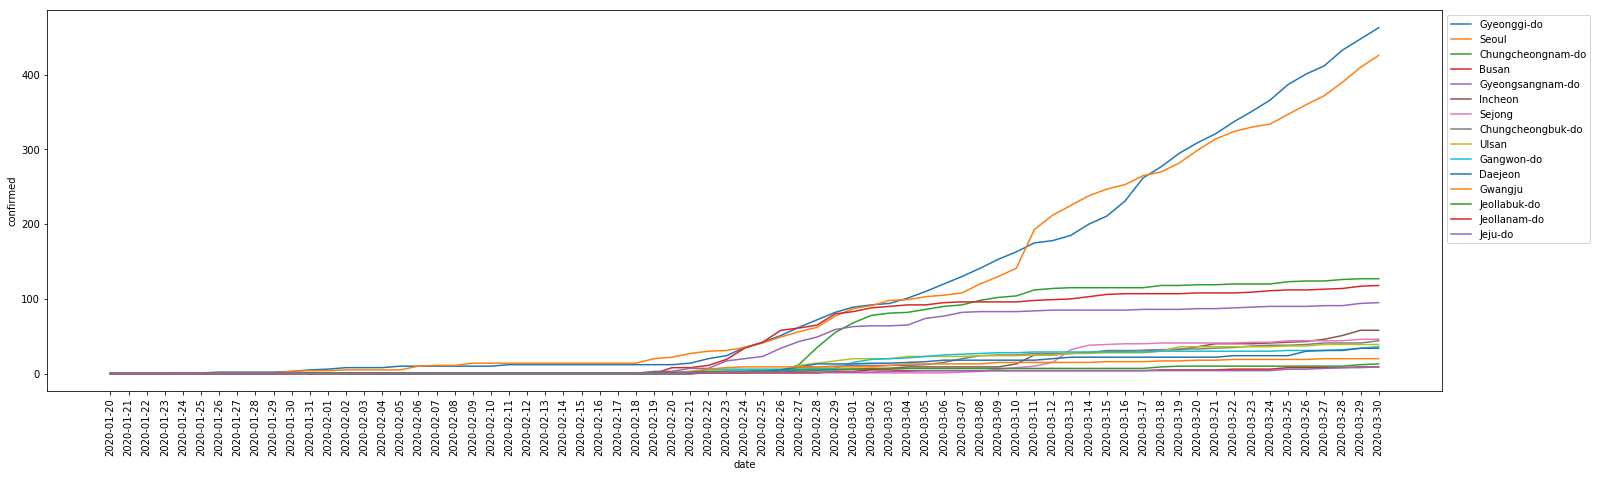

In [6]:
# 지역별 확진자 누적 그래프(대구, 경북 지역 제외)
plt.figure(figsize=(25, 7))
for p in province_list:
    sns.lineplot(x=TimeProvince_df[TimeProvince_df.province == p].date, y=TimeProvince_df[TimeProvince_df.province == p].confirmed, label=p)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

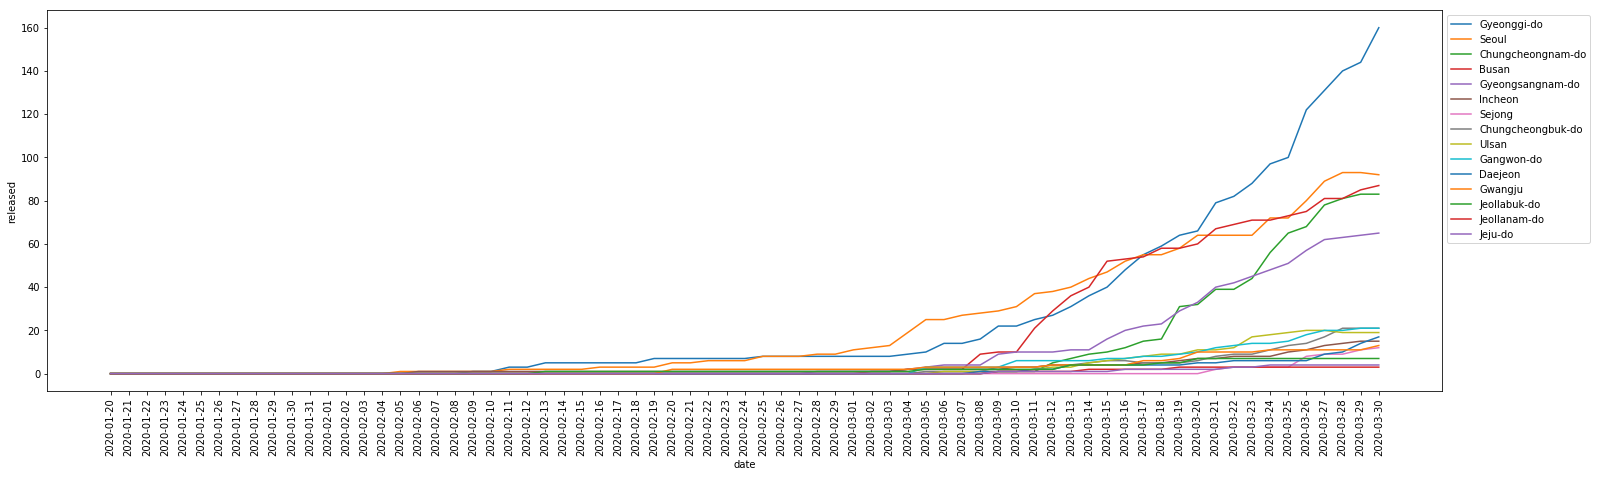

In [7]:
# 지역별 완치자 누적 그래프(대구, 경북 지역 제외)
plt.figure(figsize=(25, 7))
for p in province_list:
    sns.lineplot(x=TimeProvince_df[TimeProvince_df.province == p].date, y=TimeProvince_df[TimeProvince_df.province == p].released, label=p)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

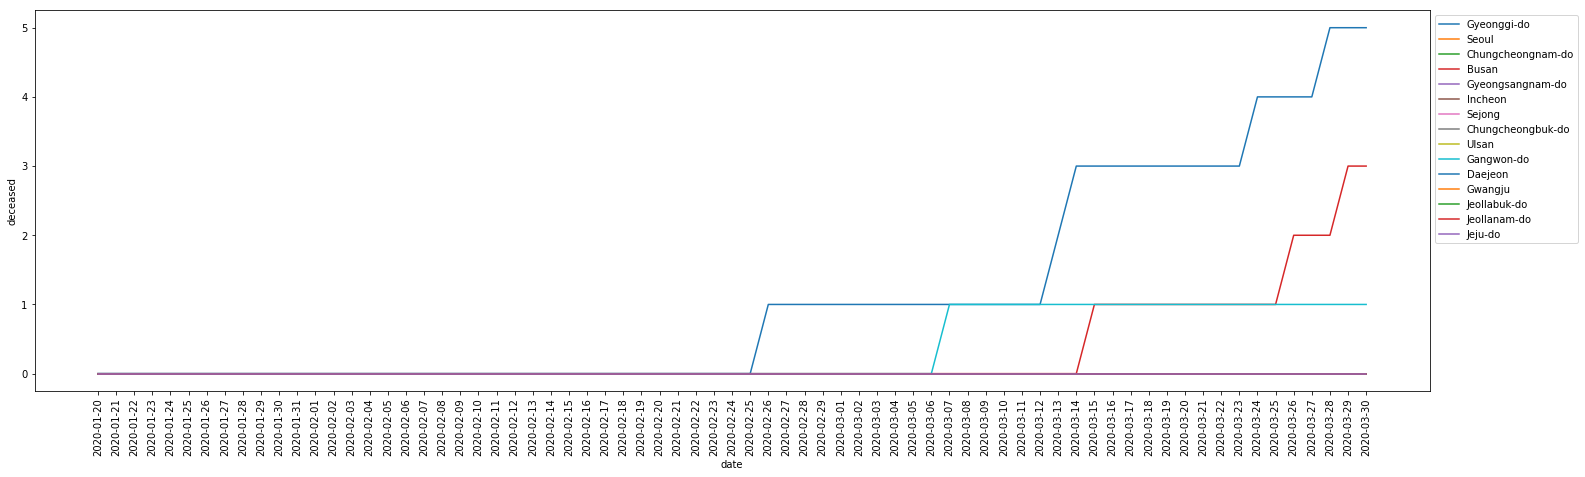

In [8]:
# 지역별 사망자 누적 그래프(대구, 경북 지역 제외)
plt.figure(figsize=(25, 7))
for p in province_list:
    sns.lineplot(x=TimeProvince_df[TimeProvince_df.province == p].date, y=TimeProvince_df[TimeProvince_df.province == p].deceased, label=p)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## 3. 개별 환자 정보 결측치 확인 - PatientInfo.csv
- 개별 환자 데이터는 결측치 및 실제 데이터와의 괴리가 커 분석에 착수하기 어려워 보임
- 제한적인 주제에만 사용하거나, 지자체별 홈페이지에서 직접 데이터를 크롤링해 사용해야 할 것으로 생각됨

In [9]:
PatientInfo_df = pd.read_csv('/kaggle/input/coronavirusdataset/PatientInfo.csv')
PatientInfo_df.head()

,patient_id,global_num,sex,birth_year,age,country,province,city,disease,infection_case,infection_order,infected_by,contact_number,symptom_onset_date,confirmed_date,released_date,deceased_date,state
0,1000000001,2.0,male,1964.0,50s,Korea,Seoul,Gangseo-gu,NaN,overseas inflow,1.0,NaN,75.0,2020-01-22,2020-01-23,2020-02-05,NaN,released
1,1000000002,5.0,male,1987.0,30s,Korea,Seoul,Jungnang-gu,NaN,overseas inflow,1.0,NaN,31.0,NaN,2020-01-30,2020-03-02,NaN,released
2,1000000003,6.0,male,1964.0,50s,Korea,Seoul,Jongno-gu,NaN,contact with patient,2.0,2.002000e+09,17.0,NaN,2020-01-30,2020-02-19,NaN,released
3,1000000004,7.0,male,1991.0,20s,Korea,Seoul,Mapo-gu,NaN,overseas inflow,1.0,NaN,9.0,2020-01-26,2020-01-30,2020-02-15,NaN,released
4,1000000005,9.0,female,1992.0,20s,Korea,Seoul,Seongbuk-gu,NaN,contact with patient,2.0,1.000000e+09,2.0,NaN,2020-01-31,2020-02-24,NaN,released


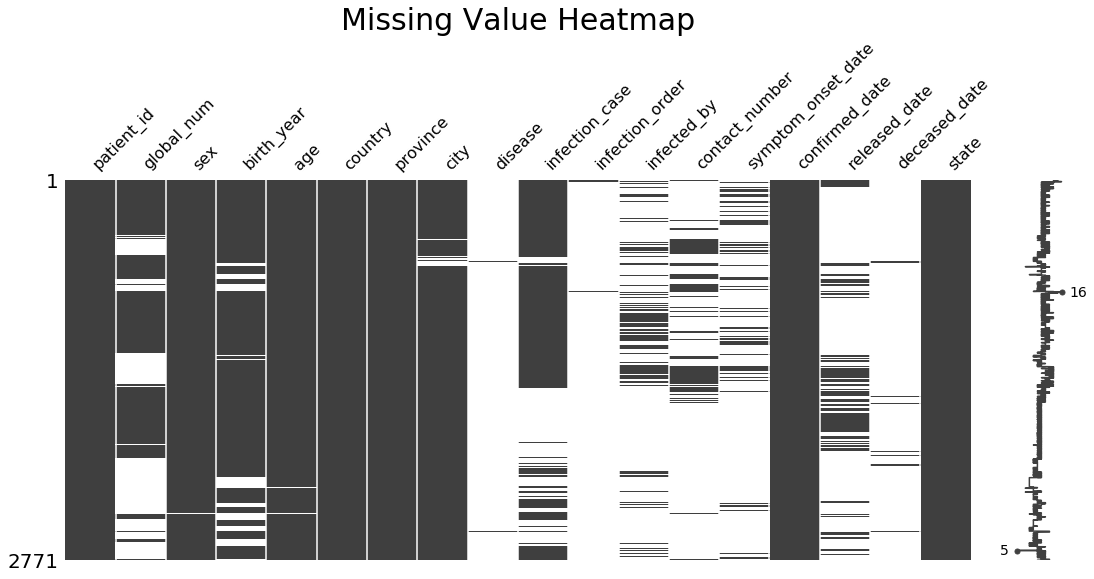

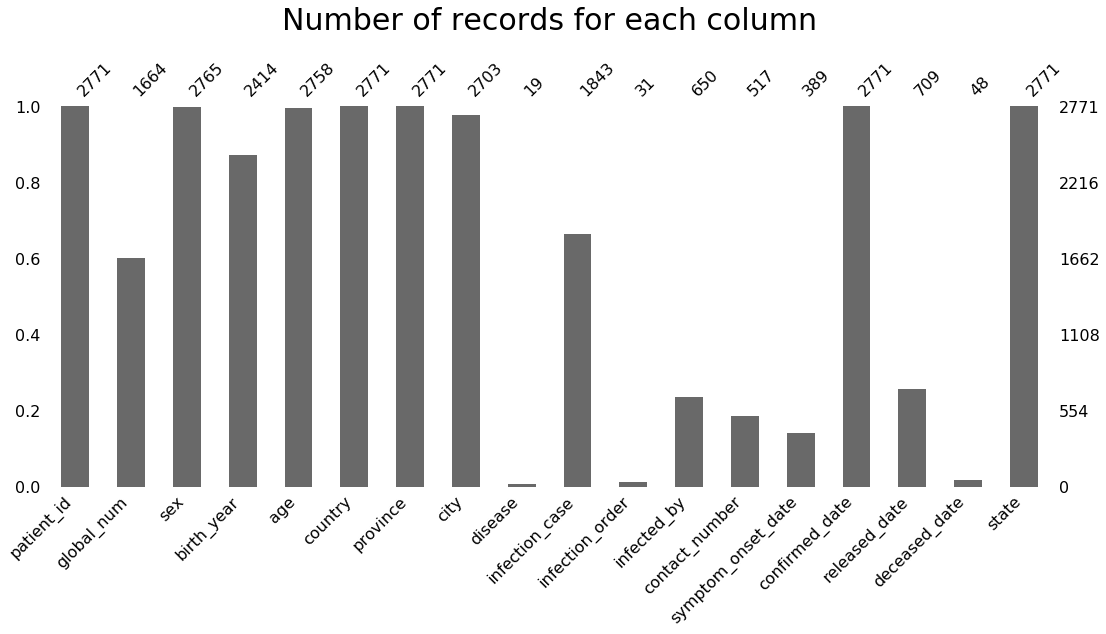

In [10]:
import missingno as msno

# 히트맵 - 하얗게 나타나는 부분이 결측치
ax = msno.matrix(PatientInfo_df, figsize=(18, 7), inline=False)
ax.set_title('Missing Value Heatmap', fontdict={'fontsize':30}, pad=150)
plt.show()

# 막대 그래프 - 각 컬럼에 저장된 데이터 레코드 수 확인
ax = msno.bar(PatientInfo_df, figsize=(18, 7), inline=False)
ax.set_title('Number of records for each column', fontdict={'fontsize':30}, pad=30)
plt.show()

In [11]:
# 각 컬럼의 결측치 비율 출력
missing_ratio = PatientInfo_df.isnull().sum()/PatientInfo_df.shape[0] * 100
round(missing_ratio, ndigits=1)

patient_id             0.0
global_num            39.9
sex                    0.2
birth_year            12.9
age                    0.5
country                0.0
province               0.0
city                   2.5
disease               99.3
infection_case        33.5
infection_order       98.9
infected_by           76.5
contact_number        81.3
symptom_onset_date    86.0
confirmed_date         0.0
released_date         74.4
deceased_date         98.3
state                  0.0
dtype: float64

## 4. 성별 확진/사망 누적 그래프 - TimeGender.csv
- 확진자는 여성이 1.5배 정도 많은 데 비해, 사망자는 남성이 약간 더 많은 것으로 나타남
- 위 차이가 단순히 성별이라는 차이 때문인지, 아니면 성별 내의 연령/기저질환 구성비 차이 때문인지 더 알아볼 필요가 있어 보임
- 위 차이가 대구, 경북 지역을 제외한 타 지역에서도 동일하게 관측되는 현상인지 더 알아볼 필요가 있어 보임

In [12]:
TimeGender_df = pd.read_csv('/kaggle/input/coronavirusdataset/TimeGender.csv')
TimeGender_df.tail(4)

,date,time,sex,confirmed,deceased
54,2020-03-29,0,male,3799,78
55,2020-03-29,0,female,5784,74
56,2020-03-30,0,male,3834,80
57,2020-03-30,0,female,5827,78


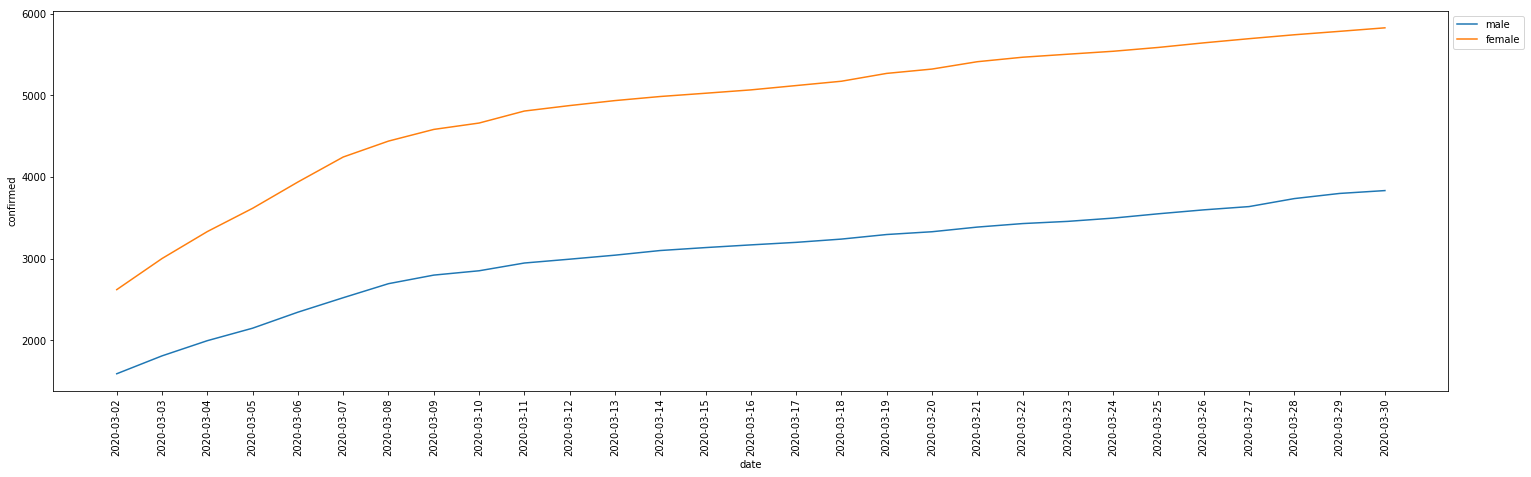

In [13]:
# 성별 확진자 누적 그래프
plt.figure(figsize=(25, 7))
for sex in ['male','female']:
    sns.lineplot(x=TimeGender_df[TimeGender_df.sex == sex].date, y=TimeGender_df[TimeGender_df.sex == sex].confirmed, label=sex)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

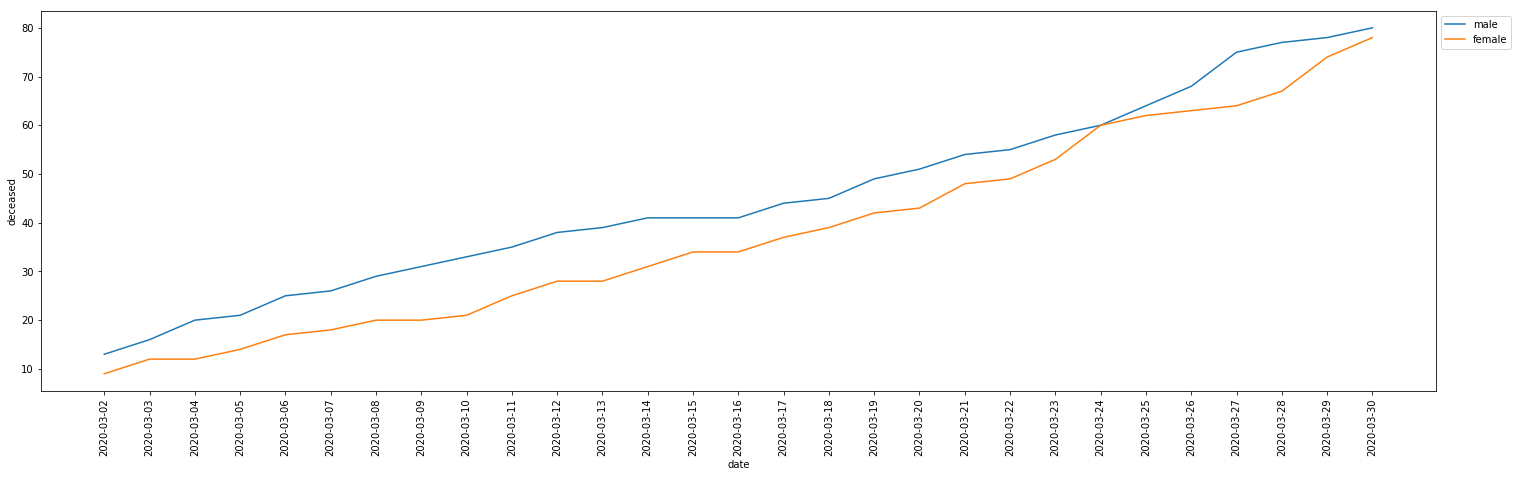

In [14]:
# 성별 사망자 누적 그래프
plt.figure(figsize=(25, 7))
for sex in ['male','female']:
    sns.lineplot(x=TimeGender_df[TimeGender_df.sex == sex].date, y=TimeGender_df[TimeGender_df.sex == sex].deceased, label=sex)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

## 5. 연령대별 확진/사망 누적 그래프 - TimeAge.csv
- 20대 확진자가 가장 많고, 50-40-60대의 중년층 확진자가 뒤를 이음
- 사망자 수는 연령대 역순으로 많은 것으로 나타나, 고령층에게 특히 치명적이라는 일반적 사실을 재확인함
- 위 차이가 대구, 경북 지역을 제외한 타 지역에서도 동일하게 관측되는 현상인지 더 알아볼 필요가 있어 보임 (특히 확진자 연령대 구성)

In [15]:
TimeAge_df = pd.read_csv('/kaggle/input/coronavirusdataset/TimeAge.csv')

# 최신 날짜의 연령별 현황 출력(확진자 순으로 내림차순 정렬)
recent_df = TimeAge_df[TimeAge_df.date == TimeAge_df.date.iloc[-1]].sort_values(by='confirmed', ascending=False)
recent_df

,date,time,age,confirmed,deceased
254,2020-03-30,0,20s,2630,0
257,2020-03-30,0,50s,1812,10
256,2020-03-30,0,40s,1297,1
258,2020-03-30,0,60s,1218,21
255,2020-03-30,0,30s,1002,1
259,2020-03-30,0,70s,640,45
253,2020-03-30,0,10s,513,0
260,2020-03-30,0,80s,437,80
252,2020-03-30,0,0s,112,0


In [16]:
age_list = recent_df.age.unique().tolist()
print(age_list)

['20s', '50s', '40s', '60s', '30s', '70s', '10s', '80s', '0s']


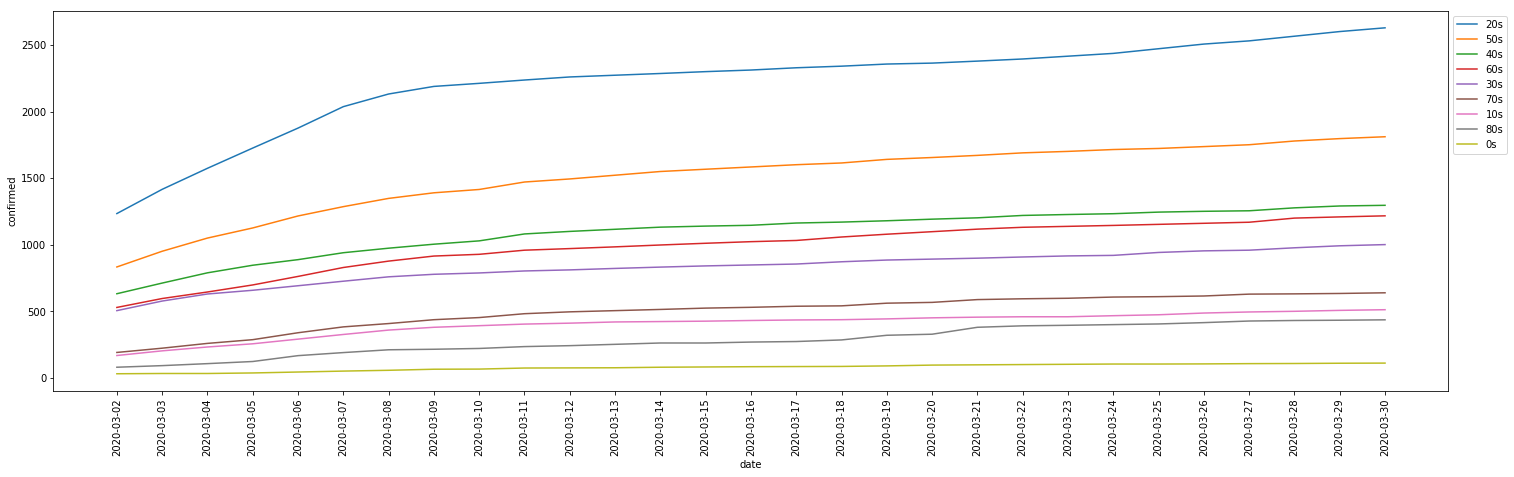

In [17]:
# 연령대별 확진자 누적 그래프
plt.figure(figsize=(25, 7))
for tmp_age in age_list:
    sns.lineplot(x=TimeAge_df[TimeAge_df.age == tmp_age].date, y=TimeAge_df[TimeAge_df.age == tmp_age].confirmed, label=tmp_age)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()

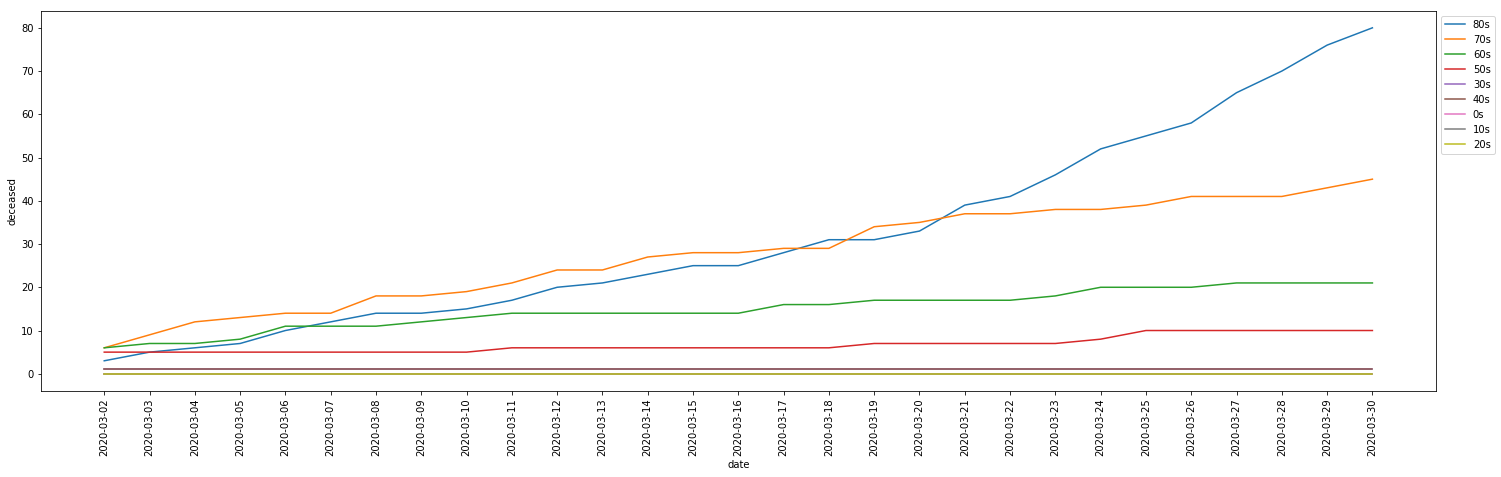

In [18]:
recent_df = TimeAge_df[TimeAge_df.date == TimeAge_df.date.iloc[-1]].sort_values(by='deceased', ascending=False)
age_list = recent_df.age.unique().tolist()


# 연령대별 사망자 누적 그래프
plt.figure(figsize=(25, 7))
for tmp_age in age_list:
    sns.lineplot(x=TimeAge_df[TimeAge_df.age == tmp_age].date, y=TimeAge_df[TimeAge_df.age == tmp_age].deceased, label=tmp_age)

plt.xticks(rotation=90)
plt.legend(bbox_to_anchor=(1, 1), loc='upper left')
plt.show()